<br><br><br><br><br>

# Histograms in Scientific Python

<br><br><br><br><br>

<br><br><br>

In scientific python, histograms seem to be considered as a plot style, on equal footing with, e.g. scatter plots.
It may well be that HEP is the only place where users predominantly work with *pre-binned* data, and thus must use histograms as persistent objects representing reduced data.  This notebook will discuss a few ways that such objects can be manipulated.

A histogram object roughly goes through three stages in its life:
   - Filling
   - Transformation
   - Plotting

<br><br><br>

<br><br><br><br><br>

### 1. Filling

<br><br><br><br><br>

<br><br><br><br>

Let's explore what solutions for filling histograms exist within numpy.  We'll use a random distribution [near and dear](https://en.wikipedia.org/wiki/ARGUS_distribution) to of b and c factory physicists as a test case.

<br><br><br><br>

In [1]:
import numpy as np
from scipy.stats import argus

vals = argus(chi=.5).rvs(size=1000)

h = np.histogram(vals)
print(h)

(array([ 21,  52,  71,  97, 122, 140, 149, 125, 139,  84]), array([0.04036875, 0.13567467, 0.23098059, 0.32628651, 0.42159243,
       0.51689835, 0.61220427, 0.70751019, 0.80281611, 0.89812203,
       0.99342795]))


<br><br><br>

So we're done, right?

<br>

Probably not: we have to analyze _O(1 billion)_ events, not _O(1000)_, and probably need to use some map-reduce paradigm to fill the histogram because we can't keep all 1 billion `vals` in memory.  So we need two things: a pre-specified binning (so that all histograms that were independently created can be added) and the ability to add two histograms.

<br><br><br>

In [2]:
def add_histos(h1, h2):
    h1sumw, h1binning = h1
    h2sumw, h2binning = h2
    if np.array_equal(h1binning, h2binning):
        return h1sumw+h2sumw, h1binning
    else:
        raise ValueError("The histograms have inconsistent binning")

In [3]:
vals2 = argus(chi=.5).rvs(size=1000)

binning = np.linspace(0, 1, 50)
h1 = np.histogram(vals, bins=binning)
h2 = np.histogram(vals, bins=binning)

h = add_histos(h1, h2)
print(h)

(array([ 0,  2,  6, 12,  8,  6, 18, 12, 24, 18, 30, 34, 22, 22, 40, 36, 24,
       46, 34, 52, 58, 46, 54, 38, 54, 60, 76, 56, 62, 56, 52, 50, 64, 86,
       78, 56, 50, 40, 52, 50, 72, 66, 54, 56, 38, 44, 24, 48, 14]), array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ]))


<br><br><br><br><br>

So now we have all the code ingredients we need to make our own version of a ROOT TH1, from a filling perspective.

<br><br><br><br><br>

In [4]:
class myTH1:
    def __init__(self, binning):
        self._binning = binning
        self._sumw = np.zeros(binning.size - 1)
    
    def fill(self, values, weights=None):
        sumw, _ = np.histogram(values, bins=self._binning, weights=weights)
        self._sumw += sumw
    
    def __add__(self, other):
        if not isinstance(other, myTH1):
            raise ValueError
        if not np.array_equal(other._binning, self._binning):
            raise ValueError("The histograms have inconsistent binning")
        out = myTH1(self._binning)
        out._sumw = self._sumw + other._sumw
        return out

In [5]:
binning = np.linspace(0, 1, 50)

h1 = myTH1(binning)
h1.fill(vals)

h2 = myTH1(binning)
h2.fill(vals2)

h = h1 + h2
print(h._sumw)

[ 0.  5.  6. 10. 12. 10. 22. 17. 23. 19. 26. 27. 22. 23. 35. 35. 23. 42.
 44. 55. 48. 38. 54. 34. 48. 53. 75. 59. 55. 56. 64. 58. 64. 70. 78. 56.
 56. 52. 58. 53. 56. 61. 61. 56. 45. 44. 27. 49. 16.]


<br><br>

**Homework:** add `sumw2` support.

<br>

Of course, we might want multidimensional histograms.  There is `np.histogram2d` and even `np.histogramdd`:

```python
xyz = np.random.multivariate_normal(mean=[1, 3, 7], cov=np.eye(3), size=10000)

binning = np.linspace(-10, 10, 20)
hnumpy = np.histogramdd(xyz, bins=(binning, binning, binning))
```

This is the extent of native numpy histogram filling support.

<br><br>

<br>

There are many histogramming libraries based on the scientific python stack that implement extended features for filling.  A non-exhaustive list:
   - [fast-histogram](https://github.com/astrofrog/fast-histogram)
   - [physt](https://github.com/janpipek/physt)
   - [histbook](https://github.com/scikit-hep/histbook) (_deprecated_)
   - [coffea.hist](https://github.com/CoffeaTeam/coffea)
   - [boost-histogram](https://github.com/scikit-hep/boost-histogram) (_in beta_)
 
The extensions (with respect to filling) focus to varying degrees on:
   - speed
   - improved book-keeping of variables
   - support for additional axis types beyond binned real-valued axes
   - support for additional accumulators beyond \$\sum w_i\$
   
Below, we demonstrate filling with the [coffea histogram](https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Hist.html) object.  The syntax is quite similar for [boost-histogram](https://boost-histogram.readthedocs.io/en/latest/usage/quickstart.html#making-a-histogram) as well.

<br>

In [6]:
import coffea.hist as hist

h = hist.Hist("Counts",
              hist.Cat("sample", "sample name"),
              hist.Bin("x", "x position [cm]", 20, -10, 10),
              hist.Bin("y", "y position [cm]", 20, -10, 10),
              hist.Bin("z", "z position [cm]", 20, -10, 10),
             )

xyz = np.random.multivariate_normal(mean=[1, 3, 7], cov=np.eye(3), size=10000)
h.fill(sample="sample 1", x=xyz[:,0], y=xyz[:,1], z=xyz[:,2])

# suppose we have another sample of xyz values
xyz_sample2 = np.random.multivariate_normal(mean=[1, 3, 7], cov=np.eye(3), size=10000)

# additionally, lets assume entries in sample 2 have some complicated weight associated
weight = np.arctan(np.sqrt(np.power(xyz_sample2, 2).sum(axis=1)))

h.fill(sample="sample 2",  # each variable is specified as a keyword argument
       x=xyz_sample2[:,0],
       y=xyz_sample2[:,1],
       z=xyz_sample2[:,2],
       weight=weight  # weight is a reserved keyword in Hist
      )

print(h)

<Hist (sample,x,y,z) instance at 0x7d0a20202710>


<br><br><br><br><br>

### 2. Transformation

<br><br><br><br><br>

<br><br>

A (multidimensional) histogram object can be transformed in any way that preserves or reduces the binning, such as
   - Integration
   - Rebinning
   - Scaling
   
and all of these can be done on one or several axes.  Most of the previously mentioned histogramming libraries support these operations.

<br>

Here are a few examples of transformations on multidimensional histograms in Coffea, to motivate why treating histograms as high-dimensional manipulatable objects can be useful.  For each, the docstring (`help(function)` or shift+tab in Jupyter) provides useful info.

<br><br>

In [7]:
# sum all x bins within nominal range (-10, 10)
h.sum("x", overflow='none')

<Hist (sample,y,z) instance at 0x7d0a042d68d0>

In [8]:
# integrate y bins from -2 to +10 and remove y axis from histogram
h.project("y", slice(0, 10))

<Hist (sample,x,z) instance at 0x7d0a042e6eb8>

In [9]:
# rebin z axis by providing a new axis definition
h.rebin("z", hist.Bin("znew", "rebinned z value", [-10, -6, 6, 10]))

<Hist (sample,x,y,znew) instance at 0x7d0a042e6cf8>

In [10]:
# merge categorical axes
mapping = {
    'all samples': ['sample 1', 'sample 2'],
    'just sample 1': ['sample 1'],
}
h.group(hist.Cat("cat", "new category"), "sample", mapping)

<Hist (cat,x,y,z) instance at 0x7d0a042e6e80>

In [11]:
# scale entire histogram by 3 (in-place)
h.scale(3.)

In [12]:
# scale samples by different values
scales = {
    'sample 1': 1.2,
    'sample 2': 0.2,
}
h.scale(scales, axis='sample')

In [13]:
# print bins, aka 'identifiers'
display(h.identifiers('sample'))
display(h.identifiers('x'))

[<StringBin (sample 1) instance at 0x7d0a2019f400>,
 <StringBin (sample 2) instance at 0x7d09f60a9ac8>]

[<Interval ([-10, -9)) instance at 0x7d0a042f4080>,
 <Interval ([-9, -8)) instance at 0x7d0a042f4828>,
 <Interval ([-8, -7)) instance at 0x7d0a042f42e8>,
 <Interval ([-7, -6)) instance at 0x7d09f60a9128>,
 <Interval ([-6, -5)) instance at 0x7d09f60a90f0>,
 <Interval ([-5, -4)) instance at 0x7d09f60a91d0>,
 <Interval ([-4, -3)) instance at 0x7d09f60a9208>,
 <Interval ([-3, -2)) instance at 0x7d09f60a9240>,
 <Interval ([-2, -1)) instance at 0x7d09f60a9278>,
 <Interval ([-1, 0)) instance at 0x7d09f60a92b0>,
 <Interval ([0, 1)) instance at 0x7d09f60a92e8>,
 <Interval ([1, 2)) instance at 0x7d09f60a9320>,
 <Interval ([2, 3)) instance at 0x7d09f60a9358>,
 <Interval ([3, 4)) instance at 0x7d09f60a9390>,
 <Interval ([4, 5)) instance at 0x7d09f60a93c8>,
 <Interval ([5, 6)) instance at 0x7d09f60a9400>,
 <Interval ([6, 7)) instance at 0x7d09f60a9438>,
 <Interval ([7, 8)) instance at 0x7d09f60a9470>,
 <Interval ([8, 9)) instance at 0x7d09f60a94a8>,
 <Interval ([9, 10)) instance at 0x7d09f60a94e0>]

<br><br><br>

There is some analog to fancy array slicing (of Numpy fame) for histogram objects, which is supported (with reasonable consistency) in Coffea.  Here, the slice boundaries are interpreted as physical axis values, rather than bin indices.  All values outside the slice range are merged into overflow bins.

<br>

For a lengthy discussion on possible histogram slicing syntax for the future, see [boost-histogram#35](https://github.com/scikit-hep/boost-histogram/issues/35).

<br><br><br>

In [14]:
sliced = h[:,0:,4:,0:]
display(sliced)
display(sliced.identifiers("y", overflow='all'))

<Hist (sample,x,y,z) instance at 0x7d0a042d69e8>

[<Interval ((-inf, 4)) instance at 0x7d0a0430e7f0>,
 <Interval ([4, 5)) instance at 0x7d0a0430e828>,
 <Interval ([5, 6)) instance at 0x7d0a0430edd8>,
 <Interval ([6, 7)) instance at 0x7d0a0430ee10>,
 <Interval ([7, 8)) instance at 0x7d0a0430ee80>,
 <Interval ([8, 9)) instance at 0x7d0a0430ee48>,
 <Interval ([9, 10)) instance at 0x7d0a0430eeb8>,
 <Interval ([10, inf)) instance at 0x7d0a0430eef0>]

In [15]:
# bin contents are accessed using Hist.values()
h.sum('x', 'y').values(sumw2=False)

{('sample 1',): array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 3.60000e+00, 3.24000e+01, 7.70400e+02,
        5.03640e+03, 1.25604e+04, 1.20744e+04, 4.74840e+03, 7.34400e+02]),
 ('sample 2',): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.08933567e-01, 4.89224300e+00, 1.71204039e+02, 1.19003443e+03,
        2.90009134e+03, 2.95578982e+03, 1.23395049e+03, 1.77331091e+02])}

In [16]:
# data can be exported to ROOT via uproot, but only 1D (and soon 2D)
import uproot
outputfile = uproot.recreate("output.root")
hout = h.sum('x', 'y')
for sample in hout.identifiers('sample'):
    outputfile[sample.name] = hist.export1d(hout.project('sample', sample))
outputfile.close()

<br><br><br><br><br>

### 3. Plotting

<br><br><br><br><br>

<br><br><br>

The most integrated plotting utility in the scientific python ecosystem, by far, is [Matplotlib](https://matplotlib.org/).  However, as we will see, it is not tailored to HEP needs.  To facilitate the transition, there is a developing package called [mpl-hep](https://github.com/nsmith-/mpl-hep#mpl-hep).  Meanwhile, Coffea tools provide several convenience functions to aid in plotting `Hist` objects.

<br>

Let's start by looking at basic "mpl" histogramming.

<br><br><br>

In [17]:
# Jupyter display backends for matplotlib: nbagg, inline, etc.
%matplotlib inline
import matplotlib.pyplot as plt

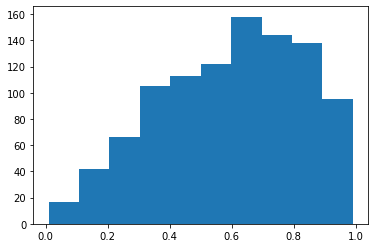

In [18]:
vals = argus(chi=.5).rvs(size=1000)

# notice the semicolon, which prevents display of the return values
plt.hist(vals);

<br><br><br><br>

Suppose we want to plot pre-binned data, for example from our earlier `np.histogram` usage.  Here we start running into the edge of typical mpl usage.  As mentioned before, apparently HEP is the only regular user of pre-binned histograms.

<br><br><br><br>

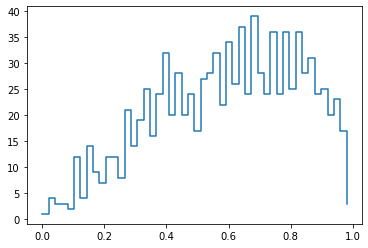

In [19]:
binning = np.linspace(0, 1, 50)

h1vals, h1bins = np.histogram(vals, bins=binning)
plt.step(x=h1bins[:-1], y=h1vals, where='post');

<br><br><br><br><br>

Coffea utilities include a plotting package to aid in displaying pre-binned histograms.  Here are a small set of example plots that can be made using this utility.  More examples can be found in [this notebook](https://github.com/CoffeaTeam/coffea/blob/master/binder/plotting-demo.ipynb).

<br><br><br><br><br>

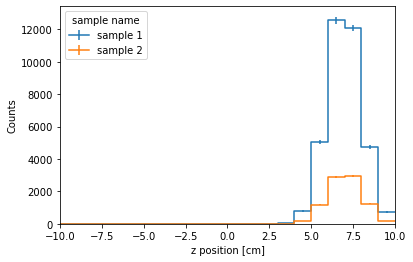

In [20]:
hist.plot1d(h.sum("x", "y"), overlay='sample');

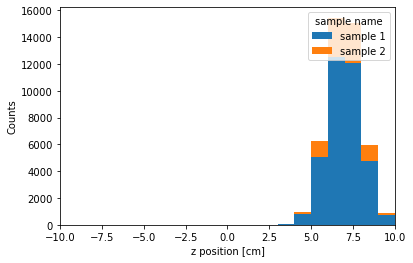

In [21]:
hist.plot1d(h.sum("x", "y"), overlay='sample', stack=True);

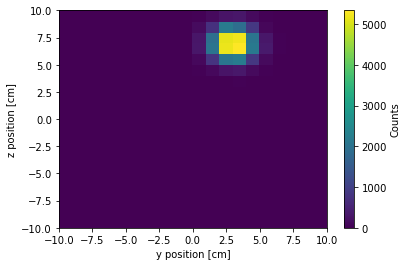

In [22]:
hist.plot2d(h.sum('x', 'sample'), xaxis='y');

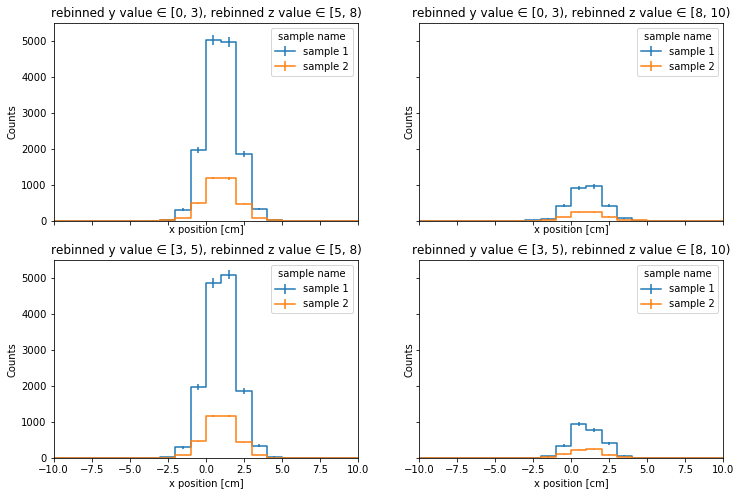

In [23]:
# make coarse binned hist and look at several distributions
hnew = (h.rebin("y", hist.Bin("ynew", "rebinned y value", [0, 3, 5]))
        .rebin("z", hist.Bin("znew", "rebinned z value", [5, 8, 10]))
       )

hist.plotgrid(hnew, row='ynew', col='znew', overlay='sample');

/home/jpivarski/miniconda3/lib/python3.7/site-packages/coffea/hist/plot.py:313: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


(-10, 10)

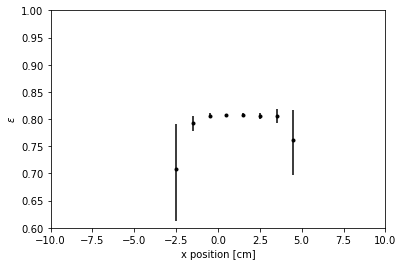

In [24]:
numerator = h.project('sample', 'sample 1').sum('y', 'z')
denominator = h.sum('sample', 'y', 'z')

numerator.label = r'$\epsilon$'
fig, ax, _ = hist.plotratio(num=numerator,
                            denom=denominator,
                            error_opts={'color': 'k', 'marker': '.'},
                            unc='clopper-pearson'
                           )
ax.set_ylim(0.6, 1.)
ax.set_xlim(-10, 10)